In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 45.9 MB/s 
     |████████████████████████████████| 144 kB 51.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=dcd518215967acd992ec1502a2a528a52dfb505d302997eb2537b6ea9a65d606
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
wandb.init(project="Assignment1-FeedFwdNeuralNw", entity="cs21s048-cs21s058")

wandb: Currently logged in as: cs21s048-cs21s058 (use `wandb login --relogin` to force relogin)


In [4]:
sweep_config = {
    "method":"random"
}
metric = {
    "name" : "val_accuracy",
    "goal" : "maximize"
}

sweep_config['metric']=metric

parameter_dict = {
      "epochs" : {
      "values" : [5, 10]
      },
      "learning_rate" : {
      "values" : [1e-3, 1e-4]
      },
      "h_layers" : {
      "values" : [3, 4, 5]
      },
      "neurons" : {
      "values" : [32, 64, 128]
      },
      "optimizer" : {
      "values" : ['sgd', 'mgd', 'nesterov', 'rmsprop', 'adam', 'nadam']  
      },
      "batch_size" : {
      "values" : [16, 32, 64]
      },
      "activation" : {
      "values" : ['sigmoid', 'tanh', 'relu']
      }
  }

sweep_config['parameters']=parameter_dict

import pprint

pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'relu']},
                'batch_size': {'values': [16, 32, 64]},
                'epochs': {'values': [5, 10]},
                'h_layers': {'values': [3, 4, 5]},
                'learning_rate': {'values': [0.001, 0.0001]},
                'neurons': {'values': [32, 64, 128]},
                'optimizer': {'values': ['sgd',
                                         'mgd',
                                         'nesterov',
                                         'rmsprop',
                                         'adam',
                                         'nadam']}}}
Create sweep with ID: f3zmmo8z
Sweep URL: https://wandb.ai/cs21s048-cs21s058/uncategorized/sweeps/f3zmmo8z


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

###Activation Functions

In [6]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def d_sigmoid(x):
  return (1 - sigmoid(x)) * sigmoid(x)

def tanh(x):
  return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
  return np.where(np.asarray(x) > 0, x, 0)

def d_relu(x):
    return np.where(x <= 0, 0, 1)

def softmax(x):
    e_x = np.exp(x)
    return e_x/e_x.sum()

###Loss Function:

In [7]:
#cross-entropy
def cross_entropy_loss(y, y_hat, i):
  return -np.log(y_hat[y[i]][0])

#squared-error
def squared_error(y, y_hat, i):
  y_hat[y[i]][0] = (1-y_hat[y[i]])**2
  return np.sum(np.square(y_hat))

In [8]:
'''def cost(y, y_hat, i):
  
  m = y.shape[0]
  c = (1/m) * np.sum(cross_entropy_loss(y, y_hat))
  c = np.squeeze(c) 

  return c'''

'def cost(y, y_hat, i):\n  \n  m = y.shape[0]\n  c = (1/m) * np.sum(cross_entropy_loss(y, y_hat))\n  c = np.squeeze(c) \n\n  return c'

###Layer Class : parameters initialization for each layer

In [9]:
class Layer:

    activationFunc = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'relu' : (relu, d_relu),
        'softmax' : (softmax, None)
    }

    def __init__(self, inputs, neurons, activation):
        
        #Xavier initialization
        np.random.seed(33)
        sd = np.sqrt(2 / float(inputs + neurons))
        self.W = np.random.normal(0, sd, size=(neurons, inputs))  
        self.b = np.zeros((neurons, 1))
        self.act, self.d_act = self.activationFunc.get(activation)
        self.dW = 0
        self.db = 0

### Forward propagation

In [10]:
def forward_propagation(h, layers):
  m = len(layers)
  
  layers[0].a = np.dot(layers[0].W, h)
  layers[0].h = layers[0].act(layers[0].a)
  
  for j in range(1, m-1):
    layers[j].a = np.dot(layers[j].W, layers[j-1].h)
    layers[j].h = layers[j].act(layers[j].a)

  j+=1
  layers[j].a = np.dot(layers[j].W, layers[j-1].h)
  layers[j].h = softmax(layers[j].a)

  return layers[m-1].h

###Backward_propagation

In [11]:
def backward_propagation(l, y_hat, layers, inp):
  
  #one-hot vector
  e_l = np.zeros((y_hat.shape[0], 1))
  e_l[l] = 1
  
  layers[len(layers)-1].da = -(e_l - y_hat)                 #gradient w.r.t activation of last layer (a_L)
  
  for j in range(len(layers)-1, 0, -1):
                        
    layers[j].dW += np.dot(layers[j].da, (layers[j-1].h).T)
    layers[j].db += layers[j].da

    layers[j-1].dh = np.dot((layers[j].W).T, layers[j].da)
    layers[j-1].da = np.multiply(layers[j-1].dh, layers[j-1].d_act(layers[j-1].a))

  layers[0].dW += np.dot(layers[0].da, inp.T)
  layers[0].db += layers[0].da

  return layers


###Gradient Descent

In [12]:
def update_params(learning_rate, layers, batch_size):
  for layer in layers:
    layer.W = layer.W - learning_rate * layer.dW/batch_size
    layer.b = layer.b - learning_rate * layer.db/batch_size

    layer.dW = 0
    layer.db = 0

###SGD / Batch Gradient Descent

In [13]:
def sgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)
        #cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #stocastic gradient decent
        if (i+1) % batch_size == 0:
          update_params(learning_rate, layers, batch_size)

      costs.append(cost/m)
      
      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})
      
      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Momentum Gradient descent

In [14]:
def mgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #momentum gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Nesterov Gradient Descent

In [16]:
def nesterov(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.update_W
            layer.b = layer.b - gamma * layer.update_b

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #nesterov gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0

      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers  

###RMSProp

In [17]:
def rmsprop(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    epsilon, beta = 1e-8, 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #rmsprop gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = beta*layer.update_W + (1-beta)*(layer.dW/batch_size)**2
            layer.update_b = beta*layer.update_b + (1-beta)*(layer.db/batch_size)**2

            layer.W = layer.W - (learning_rate / np.sqrt(layer.update_W + epsilon)) * (layer.dW/batch_size)
            layer.b = layer.b - (learning_rate / np.sqrt(layer.update_b + epsilon)) * (layer.db/batch_size)

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Adam

In [19]:
def adam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_W_hat
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_b_hat

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###NAdam

In [20]:
def nadam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    gamma = 0.9
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)
        #cost += squared_error(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.m_W
            layer.b = layer.b - gamma * layer.m_b
        
        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.m_dash_W = beta1 * layer.m_W_hat + (1-beta1)*layer.dW/batch_size
            layer.m_dash_b = beta1 * layer.m_b_hat + (1-beta1)*layer.db/batch_size

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_dash_W
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_dash_b

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 
        #val_loss += squared_error(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Putting all togather:

###Optimizer

In [21]:
def optimizor(layers, optimizer, epochs, learning_rate, x_train, y_train, x_val, y_val, batch_size):
  
  if optimizer == "sgd":
    return sgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "mgd":
    return mgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "nesterov":
    return nesterov(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "rmsprop":
    return rmsprop(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "adam":
    return adam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "nadam":
    return nadam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  else:
    print("No optimization algorithm named "+optimizer+" found")
    return "Error", "Error"

###Function to Predict

In [22]:
def predict(input, y, layers):
 
  prediction = forward_propagation(input, layers)

  loss = 0
  for i in range(len(y)):
    #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
    loss += cross_entropy_loss(y, prediction[:, i].reshape(10,1), i) 

  prediction = prediction.argmax(axis=0)
  accuracy =  np.sum(prediction == y)/y.shape[0]

  return prediction, accuracy, loss/len(y)

###Import dataset and putting in appropriate format

In [23]:
from keras.datasets import fashion_mnist
(x_train_org, y_train_org), (x_test_org, y_test_org) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [24]:
print("x_train shape: ", x_train_org.shape)
print("y_train shape: ", y_train_org.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


###Display images corresponding to each class
(and wandb logging)

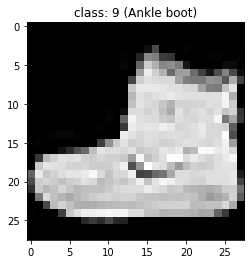

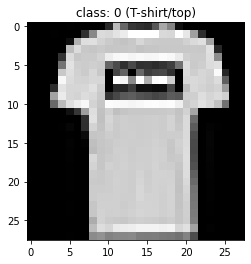

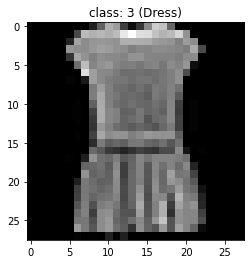

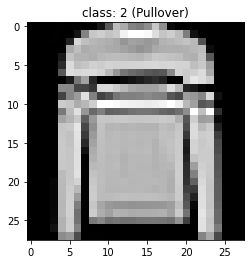

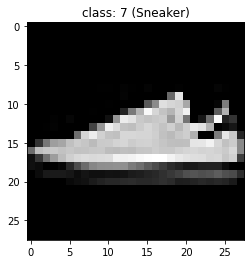

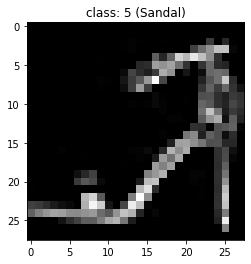

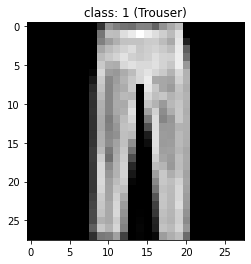

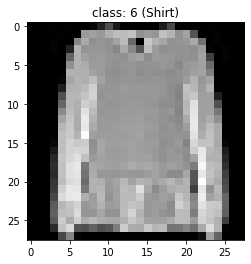

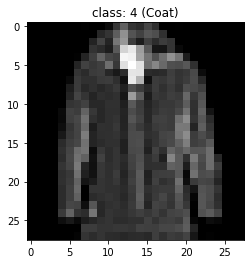

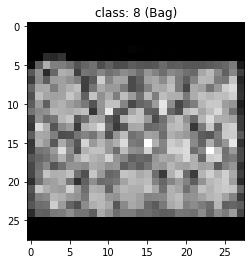

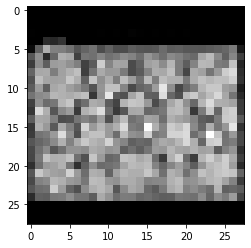

In [35]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img_list = []
idx_list = []
count = 0
for i in range(y_train_org.shape[0]):
    if y_train_org[i] in idx_list:
      continue
    else:
      idx_list.append(y_train_org[i])
      img_list.append(x_train_org[i])
    if len(idx_list) == 10:
      break

wandb_list = []
for j in range(10):
  plt.imshow(img_list[j], cmap='gray')
  plt.title("class: "+ str(idx_list[j]) + " ("+labels[idx_list[j]]+")")
  #wandb.log({"img": [wandb.Image(plt.imshow(img_list[j], cmap='gray'), caption="class: "+ str(idx_list[j]) + " ("+labels[idx_list[j]]+")")]})
  plt.show()

wandb.log({"class: "+ str(idx_list[0]) + " ("+labels[idx_list[0]]+")": [wandb.Image(plt.imshow(img_list[0], cmap='gray'))],
              "class: "+ str(idx_list[1]) + " ("+labels[idx_list[1]]+")": [wandb.Image(plt.imshow(img_list[1], cmap='gray'))],
             "class: "+ str(idx_list[2]) + " ("+labels[idx_list[2]]+")": [wandb.Image(plt.imshow(img_list[2], cmap='gray'))],
             "class: "+ str(idx_list[3]) + " ("+labels[idx_list[3]]+")": [wandb.Image(plt.imshow(img_list[3], cmap='gray'))],
             "class: "+ str(idx_list[4]) + " ("+labels[idx_list[4]]+")": [wandb.Image(plt.imshow(img_list[4], cmap='gray'))],
             "class: "+ str(idx_list[5]) + " ("+labels[idx_list[5]]+")": [wandb.Image(plt.imshow(img_list[5], cmap='gray'))],
             "class: "+ str(idx_list[6]) + " ("+labels[idx_list[6]]+")": [wandb.Image(plt.imshow(img_list[6], cmap='gray'))],
             "class: "+ str(idx_list[7]) + " ("+labels[idx_list[7]]+")": [wandb.Image(plt.imshow(img_list[7], cmap='gray'))],
             "class: "+ str(idx_list[8]) + " ("+labels[idx_list[8]]+")": [wandb.Image(plt.imshow(img_list[8], cmap='gray'))],
             "class: "+ str(idx_list[9]) + " ("+labels[idx_list[9]]+")": [wandb.Image(plt.imshow(img_list[9], cmap='gray'))]})

#images = wandb.Image(img_list, caption="class": Output, Bottom: Input")
#wandb.log({"example": [wandb.Image(img) for img in img_list]})



####Flattening the data

In [25]:
x_train_temp = x_train_org.reshape(x_train_org.shape[0], -1)
y_train_temp = y_train_org
x_test = x_test_org.reshape(x_test_org.shape[0], -1)
y_test = y_test_org

####Splliting dataset into training and validation

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.1, random_state=33)

In [ ]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (54000, 784)
y_train shape:  (54000,)
x_val shape:  (6000, 784)
y_val shape:  (6000,)
x_test shape:  (10000, 784)
y_test shape:  (10000,)


###Train model

In [27]:
def model_train(epochs, learning_rate, neurons, h_layers, activation, batch_size, optimizer, x_train, y_train, x_val, y_val):

  layers= [Layer(x_train.shape[1], neurons, activation)]
  for _ in range(0, h_layers-1):
    layers.append(Layer(neurons, neurons, activation))
  layers.append(Layer(neurons, 10, 'softmax'))

  costs, layers = optimizor(layers, optimizer, epochs, learning_rate, x_train, y_train, x_val, y_val, batch_size)

  output_test, accuracy_test, loss_test = predict(x_test.T, y_test, layers)

  print("Test accuracy: ", accuracy_test)
  print("Test loss: ", loss_test)

  return output_test

###Train Model with wandb

In [28]:
def model_train_wandb(config=None):

  with wandb.init(config=config):
    config=wandb.config

    layers= [Layer(x_train.shape[1], config.neurons, config.activation)]
    for _ in range(0, config.h_layers-1):
      layers.append(Layer(config.neurons, config.neurons, config.activation))
    layers.append(Layer(config.neurons, 10, 'softmax'))

    costs, layers = optimizor(layers, config.optimizer, config.epochs, config.learning_rate, x_train, y_train, x_val, y_val, config.batch_size)

    #output_val, accuracy_val, loss_val = predict(x_val.T, y_val, layers)
    output_test, accuracy_test, loss_test = predict(x_test.T, y_test, layers)

    #wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": accuracy_val, "accuracy": accuracy_test, "val_loss": loss_val})
    wandb.log({"accuracy": accuracy_test})

    #print("Validation accuracy: ", accuracy_val)
    #print("Validation loss: ", loss_val)
    print("Test accuracy: ", accuracy_test)
    print("Test loss: ", loss_test)

In [ ]:
wandb.agent(sweep_id, model_train_wandb, count=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Agent Starting Run: ofm24t6a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: mgd


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


-----------------epoch 0-----------------
Cost:  2.4579936767773924
Validation accuracy:  0.10133333333333333
Validation loss:  11.077744356213385
-----------------epoch 1-----------------
Cost:  2.338714489468631
Validation accuracy:  0.15083333333333335
Validation loss:  11.01182883223719
-----------------epoch 2-----------------
Cost:  2.2960080309691366
Validation accuracy:  0.19666666666666666
Validation loss:  10.984022883097708
-----------------epoch 3-----------------
Cost:  2.2772906152684897
Validation accuracy:  0.2355
Validation loss:  10.971183208434947
-----------------epoch 4-----------------
Cost:  2.2676794248915217
Validation accuracy:  0.2971666666666667
Validation loss:  10.963400652546122
-----------------epoch 5-----------------
Cost:  2.260717224386893
Validation accuracy:  0.3471666666666667
Validation loss:  10.95688761115893
-----------------epoch 6-----------------
Cost:  2.254316093922982
Validation accuracy:  0.39366666666666666
Validation loss:  10.9505292

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.4461
epoch,9
loss,2.23445
val_accuracy,0.4465
val_loss,10.92988


wandb: Agent Starting Run: t7uz9n74 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  1.0711864755623557
Validation accuracy:  0.6688333333333333
Validation loss:  17.05970161549953
-----------------epoch 1-----------------
Cost:  0.9742522716738352
Validation accuracy:  0.6728333333333333
Validation loss:  26.513708764446434
-----------------epoch 2-----------------
Cost:  0.975763350202504
Validation accuracy:  0.6696666666666666
Validation loss:  30.98471894621031
-----------------epoch 3-----------------
Cost:  0.9448914238072362
Validation accuracy:  0.664
Validation loss:  47.01406957188663
-----------------epoch 4-----------------
Cost:  0.9213571164593013
Validation accuracy:  0.685
Validation loss:  44.15662329844811
Test accuracy:  0.6862
Test loss:  44.39017497464543


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▄▂▁
val_accuracy,▃▄▃▁█
val_loss,▁▃▄█▇
accuracy,0.6862
epoch,4
loss,0.92136
val_accuracy,0.685
val_loss,44.15662


wandb: Agent Starting Run: 06ibk9qe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  0.7380084396247136
Validation accuracy:  0.7891666666666667
Validation loss:  10.329023761873039
-----------------epoch 1-----------------
Cost:  0.5588940867273678
Validation accuracy:  0.8026666666666666
Validation loss:  11.06134547098658
-----------------epoch 2-----------------
Cost:  0.5263537154759692
Validation accuracy:  0.8151666666666667
Validation loss:  11.543009698725633
-----------------epoch 3-----------------
Cost:  0.5021488670285541
Validation accuracy:  0.8203333333333334
Validation loss:  11.84224204185451
-----------------epoch 4-----------------
Cost:  0.4916244984644904
Validation accuracy:  0.8211666666666667
Validation loss:  12.334376304165598
Test accuracy:  0.8181
Test loss:  12.835794654032544


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▇██
val_loss,▁▄▅▆█
accuracy,0.8181
epoch,4
loss,0.49162
val_accuracy,0.82117
val_loss,12.33438


wandb: Agent Starting Run: yehsjnzt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.3061347444907772
Validation accuracy:  0.6685
Validation loss:  30.370186434496656
-----------------epoch 1-----------------
Cost:  0.7258731799205308
Validation accuracy:  0.6906666666666667
Validation loss:  33.15256184376415
-----------------epoch 2-----------------
Cost:  0.6725608935051227
Validation accuracy:  0.7118333333333333
Validation loss:  32.5572386286678
-----------------epoch 3-----------------
Cost:  0.6287033205166995
Validation accuracy:  0.738
Validation loss:  34.23310025334654
-----------------epoch 4-----------------
Cost:  0.5892436627284211
Validation accuracy:  0.774
Validation loss:  32.31679710207061
-----------------epoch 5-----------------
Cost:  0.562022581489504
Validation accuracy:  0.791
Validation loss:  32.415287172690356
-----------------epoch 6-----------------
Cost:  0.5420880999874382
Validation accuracy:  0.7855
Validation loss:  33.10791180105861
-----------------epoch 7-----------------
Cost: 

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▅▇▇▇▇▇█
val_loss,▁▅▄▇▄▄▅▆▅█
accuracy,0.8005
epoch,9
loss,0.50352
val_accuracy,0.80267
val_loss,35.11256


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9am2q8t2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.401999515872126
Validation accuracy:  0.09616666666666666
Validation loss:  11.022802797249033
-----------------epoch 1-----------------
Cost:  2.309691214908761
Validation accuracy:  0.09616666666666666
Validation loss:  11.004036465427024
-----------------epoch 2-----------------
Cost:  2.3032979161688942
Validation accuracy:  0.09616666666666666
Validation loss:  11.002437858789078
-----------------epoch 3-----------------
Cost:  2.3027977064042946
Validation accuracy:  0.096
Validation loss:  11.002260597564327
-----------------epoch 4-----------------
Cost:  2.3027417964398613
Validation accuracy:  0.0865
Validation loss:  11.002216956108287
-----------------epoch 5-----------------
Cost:  2.3027167071178885
Validation accuracy:  0.08716666666666667
Validation loss:  11.002189256919415
-----------------epoch 6-----------------
Cost:  2.302692968209768
Validation accuracy:  0.09616666666666666
Validation loss:  11.002164360153492
-

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▅▅▅▅▁▁▅▆▇█
val_loss,█▂▁▁▁▁▁▁▁▁
accuracy,0.1008
epoch,9
loss,2.30262
val_accuracy,0.10317
val_loss,11.00209


wandb: Agent Starting Run: u00vzq4e with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  3.9876004917733194
Validation accuracy:  0.7745
Validation loss:  67.66207970066422
-----------------epoch 1-----------------
Cost:  1.399945583192952
Validation accuracy:  0.7448333333333333
Validation loss:  72.57107399259719
-----------------epoch 2-----------------
Cost:  2.7928376616686243
Validation accuracy:  0.7028333333333333
Validation loss:  230.5310238293494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 9-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
Test accuracy:  0.1
Test loss:  nan


accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▅
val_accuracy,██▇▁▁▁▁▁▁▁
val_loss,▁▁█
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: r901iqmd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.6298172333992014
Validation accuracy:  0.7043333333333334
Validation loss:  48.41970996792418
-----------------epoch 1-----------------
Cost:  0.7593359490073542
Validation accuracy:  0.7505
Validation loss:  51.88521054736706
-----------------epoch 2-----------------
Cost:  0.6603336566631515
Validation accuracy:  0.772
Validation loss:  51.82503544938177
-----------------epoch 3-----------------
Cost:  0.6058637843945853
Validation accuracy:  0.7828333333333334
Validation loss:  52.56242202679804
-----------------epoch 4-----------------
Cost:  0.5696789829206338
Validation accuracy:  0.789
Validation loss:  54.745643268734625
-----------------epoch 5-----------------
Cost:  0.5421710412643918
Validation accuracy:  0.7915
Validation loss:  55.31605476926592
-----------------epoch 6-----------------
Cost:  0.5211891547251646
Validation accuracy:  0.7978333333333333
Validation loss:  55.53804898622474
-----------------epoch 7----------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,▁▄▄▅▇▇████
accuracy,0.8044
epoch,9
loss,0.47977
val_accuracy,0.80867
val_loss,55.81592


wandb: Agent Starting Run: o1e0hbg1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.1787672887048715
Validation accuracy:  0.7765
Validation loss:  22.848374390718465
-----------------epoch 1-----------------
Cost:  0.5679680541893761
Validation accuracy:  0.8003333333333333
Validation loss:  24.61563425011129
-----------------epoch 2-----------------
Cost:  0.4991558682161722
Validation accuracy:  0.8138333333333333
Validation loss:  27.12325750612204
-----------------epoch 3-----------------
Cost:  0.4620414186780647
Validation accuracy:  0.8181666666666667
Validation loss:  29.45794308763646
-----------------epoch 4-----------------
Cost:  0.4351124625875462
Validation accuracy:  0.8245
Validation loss:  30.33588493
Test accuracy:  0.8265
Test loss:  28.547072707119725


accuracy,▁
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,▁▃▅▇█
accuracy,0.8265
epoch,4
loss,0.43511
val_accuracy,0.8245
val_loss,30.33588


wandb: Agent Starting Run: ym1nqnp0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  1.2515585244622538
Validation accuracy:  0.701
Validation loss:  9.855165751545858
-----------------epoch 1-----------------
Cost:  0.7290560376388169
Validation accuracy:  0.7458333333333333
Validation loss:  9.922175644179067
-----------------epoch 2-----------------
Cost:  0.6466034791531169
Validation accuracy:  0.7675
Validation loss:  10.004776356780786
-----------------epoch 3-----------------
Cost:  0.6080588326988584
Validation accuracy:  0.7803333333333333
Validation loss:  10.034570356746986
-----------------epoch 4-----------------
Cost:  0.5827166831967938
Validation accuracy:  0.7831666666666667
Validation loss:  10.08500406302727
-----------------epoch 5-----------------
Cost:  0.5600085529050066
Validation accuracy:  0.7925
Validation loss:  10.136477331428917
-----------------epoch 6-----------------
Cost:  0.5466903311172446
Validation accuracy:  0.7991666666666667
Validation loss:  10.197301133609177
-----------------e

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,▁▂▃▃▄▅▆▆██
accuracy,0.8053
epoch,9
loss,0.51467
val_accuracy,0.80833
val_loss,10.36581


wandb: Agent Starting Run: 8fby0r6q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.8688229092468622
Validation accuracy:  0.5436666666666666
Validation loss:  10.25164233446577
-----------------epoch 1-----------------
Cost:  1.3792947951749424
Validation accuracy:  0.6313333333333333
Validation loss:  10.017621947071696
-----------------epoch 2-----------------
Cost:  1.1756473713657272
Validation accuracy:  0.6691666666666667
Validation loss:  9.879453032995714
-----------------epoch 3-----------------
Cost:  1.0510811401327547
Validation accuracy:  0.6971666666666667
Validation loss:  9.79578483238709
-----------------epoch 4-----------------
Cost:  0.967361583512081
Validation accuracy:  0.7061666666666667
Validation loss:  9.750884201063819
-----------------epoch 5-----------------
Cost:  0.9066571821383566
Validation accuracy:  0.7166666666666667
Validation loss:  9.710665597490735
-----------------epoch 6-----------------
Cost:  0.8551600753846976
Validation accuracy:  0.726
Validation loss:  9.684164560914102

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▂▁▁
accuracy,0.7449
epoch,9
loss,0.75374
val_accuracy,0.749
val_loss,9.63038


wandb: Agent Starting Run: d25ngd4s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.9192566968089497
Validation accuracy:  0.5215
Validation loss:  37.61642565022321
-----------------epoch 1-----------------
Cost:  1.0308216860543131
Validation accuracy:  0.5825
Validation loss:  43.321909674968616
-----------------epoch 2-----------------
Cost:  0.9012980898121632
Validation accuracy:  0.6153333333333333
Validation loss:  42.73715292318328
-----------------epoch 3-----------------
Cost:  0.8104609911439143
Validation accuracy:  0.6795
Validation loss:  45.30012710132429
-----------------epoch 4-----------------
Cost:  0.7310659790140948
Validation accuracy:  0.6913333333333334
Validation loss:  46.672626492966366
-----------------epoch 5-----------------
Cost:  0.6981470924312894
Validation accuracy:  0.7263333333333334
Validation loss:  49.80966592329131
-----------------epoch 6-----------------
Cost:  0.6652305084656982
Validation accuracy:  0.7346666666666667
Validation loss:  51.578427502699945
-----------------e

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,▁▄▃▄▅▇▇▇▇█
accuracy,0.7655
epoch,9
loss,0.59895
val_accuracy,0.77083
val_loss,53.03292


wandb: Agent Starting Run: ucntgoka with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  2.2785652721055114
Validation accuracy:  0.46416666666666667
Validation loss:  10.938799929312072
-----------------epoch 1-----------------
Cost:  2.208694898988918
Validation accuracy:  0.501
Validation loss:  10.869419101694735
-----------------epoch 2-----------------
Cost:  2.1178142101165425
Validation accuracy:  0.5028333333333334
Validation loss:  10.7518842428126
-----------------epoch 3-----------------
Cost:  1.9697677980904769
Validation accuracy:  0.5081666666666667
Validation loss:  10.581305263208195
-----------------epoch 4-----------------
Cost:  1.7966678289232254
Validation accuracy:  0.5265
Validation loss:  10.423602796366279
Test accuracy:  0.5207
Test loss:  10.936253098745837


accuracy,▁
epoch,▁▃▅▆█
loss,█▇▆▄▁
val_accuracy,▁▅▅▆█
val_loss,█▇▅▃▁
accuracy,0.5207
epoch,4
loss,1.79667
val_accuracy,0.5265
val_loss,10.4236


wandb: Agent Starting Run: 4auavaxn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  5.892126563821322
Validation accuracy:  0.6863333333333334
Validation loss:  116.01089488174273
-----------------epoch 1-----------------
Cost:  2.243625803025112
Validation accuracy:  0.6445
Validation loss:  61.31003816950775
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
Test accuracy:  0.1
Test loss:  nan


accuracy,▁
epoch,▁▃▅▆█
loss,█▁
val_accuracy,█▇▁▁▁
val_loss,█▁
accuracy,0.1
epoch,4
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: h7xr1k4j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  0.9033859830362674
Validation accuracy:  0.7271666666666666
Validation loss:  20.449598302416497
-----------------epoch 1-----------------
Cost:  0.5721602071024704
Validation accuracy:  0.7733333333333333
Validation loss:  21.48771500172626
-----------------epoch 2-----------------
Cost:  0.5028927651166912
Validation accuracy:  0.8001666666666667
Validation loss:  21.6756575343683
-----------------epoch 3-----------------
Cost:  0.46363924209693463
Validation accuracy:  0.8186666666666667
Validation loss:  22.591798908766272
-----------------epoch 4-----------------
Cost:  0.4361576510753931
Validation accuracy:  0.8218333333333333
Validation loss:  23.501463392315767
-----------------epoch 5-----------------
Cost:  0.41613525415330216
Validation accuracy:  0.8263333333333334
Validation loss:  25.622113242822603
-----------------epoch 6-----------------
Cost:  0.4000715243831611
Validation accuracy:  0.8303333333333334
Validation loss:

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,▁▂▂▃▄▆▆▆▇█
accuracy,0.8324
epoch,9
loss,0.36649
val_accuracy,0.837
val_loss,28.29022


wandb: Agent Starting Run: 8xtcvnhl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.2832673375933061
Validation accuracy:  0.7013333333333334
Validation loss:  28.107748226171505
-----------------epoch 1-----------------
Cost:  0.7357419187765082
Validation accuracy:  0.7301666666666666
Validation loss:  26.186657795860974
-----------------epoch 2-----------------
Cost:  0.6499548855126387
Validation accuracy:  0.7571666666666667
Validation loss:  26.014891541206648
-----------------epoch 3-----------------
Cost:  0.5988702651716508
Validation accuracy:  0.7671666666666667
Validation loss:  25.97272483267209
-----------------epoch 4-----------------
Cost:  0.5636691750308805
Validation accuracy:  0.7783333333333333
Validation loss:  26.05598296000403
-----------------epoch 5-----------------
Cost:  0.5383545250268853
Validation accuracy:  0.7863333333333333
Validation loss:  26.2252930736717
-----------------epoch 6-----------------
Cost:  0.5184398505378466
Validation accuracy:  0.7916666666666666
Validation loss:  2

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▂▁▁▁▂▂▃▃▃
accuracy,0.7999
epoch,9
loss,0.4768
val_accuracy,0.80583
val_loss,26.47623


wandb: Agent Starting Run: wxlmd4fb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  1.2183066128185163
Validation accuracy:  0.6468333333333334
Validation loss:  10.018662719338517
-----------------epoch 1-----------------
Cost:  0.8628027016072529
Validation accuracy:  0.6708333333333333
Validation loss:  11.436799123365663
-----------------epoch 2-----------------
Cost:  0.7991035620782543
Validation accuracy:  0.6606666666666666
Validation loss:  11.539406254710423
-----------------epoch 3-----------------
Cost:  0.7685555097176464
Validation accuracy:  0.7198333333333333
Validation loss:  11.281655036896773
-----------------epoch 4-----------------
Cost:  0.7570542717138121
Validation accuracy:  0.712
Validation loss:  10.916486076387676
-----------------epoch 5-----------------
Cost:  0.7432890283150926
Validation accuracy:  0.7321666666666666
Validation loss:  10.897555964597682
-----------------epoch 6-----------------
Cost:  0.7328145563968571
Validation accuracy:  0.722
Validation loss:  10.228283997775526
----

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▂▂▅▅▆▆▅▇█
val_loss,▁██▇▅▅▂▅▃▃
accuracy,0.7546
epoch,9
loss,0.7066
val_accuracy,0.76167
val_loss,10.46696


wandb: Agent Starting Run: uk602gwb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  1.1001693215999226
Validation accuracy:  0.6196666666666667
Validation loss:  17.935773197771102
-----------------epoch 1-----------------
Cost:  0.987813206598028
Validation accuracy:  0.6665
Validation loss:  28.649795723330488
-----------------epoch 2-----------------
Cost:  0.9486866427545885
Validation accuracy:  0.6721666666666667
Validation loss:  39.58025092146569
-----------------epoch 3-----------------
Cost:  0.9716823596788149
Validation accuracy:  0.656
Validation loss:  38.30428413759375
-----------------epoch 4-----------------
Cost:  0.9831327489764409
Validation accuracy:  0.6746666666666666
Validation loss:  36.67994810978203
-----------------epoch 5-----------------
Cost:  1.0085419919439194
Validation accuracy:  0.6548333333333334
Validation loss:  32.38688673526714
-----------------epoch 6-----------------
Cost:  1.0132422696418701
Validation accuracy:  0.6615
Validation loss:  35.8434347314221
-----------------epoch

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▁▂▃▄▄▃▃▄
val_accuracy,▁▇█▆█▅▆▇▃▅
val_loss,▁▄▆▆▆▅▆▆██
accuracy,0.6601
epoch,9
loss,1.00636
val_accuracy,0.6525
val_loss,43.75177


wandb: Agent Starting Run: vweh8n4x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.6835044881460643
Validation accuracy:  0.7135
Validation loss:  44.8084492330988
-----------------epoch 1-----------------
Cost:  0.8303004656069369
Validation accuracy:  0.7395
Validation loss:  43.98265344098769
-----------------epoch 2-----------------
Cost:  0.698058802428165
Validation accuracy:  0.7581666666666667
Validation loss:  45.16788071287074
-----------------epoch 3-----------------
Cost:  0.6309133257245815
Validation accuracy:  0.7723333333333333
Validation loss:  48.456675499913494
-----------------epoch 4-----------------
Cost:  0.587468706826056
Validation accuracy:  0.7808333333333334
Validation loss:  50.867123875103424
-----------------epoch 5-----------------
Cost:  0.556208474067292
Validation accuracy:  0.7883333333333333
Validation loss:  52.66786131837657
-----------------epoch 6-----------------
Cost:  0.5319009205191652
Validation accuracy:  0.792
Validation loss:  52.3173899932508
-----------------epoch 7-

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▇██
val_loss,▂▁▂▅▇███▇█
accuracy,0.8013
epoch,9
loss,0.48195
val_accuracy,0.80417
val_loss,52.18547


wandb: Agent Starting Run: jwt28u1o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.7160610469161262
Validation accuracy:  0.7406666666666667
Validation loss:  46.60595166361669
-----------------epoch 1-----------------
Cost:  0.7512926659249081
Validation accuracy:  0.7776666666666666
Validation loss:  50.327278597970725
-----------------epoch 2-----------------
Cost:  0.6260192752011228
Validation accuracy:  0.7891666666666667
Validation loss:  52.77934606229204
-----------------epoch 3-----------------
Cost:  0.5622929229495173
Validation accuracy:  0.7971666666666667
Validation loss:  52.920759145246365
-----------------epoch 4-----------------
Cost:  0.520460948595072
Validation accuracy:  0.8015
Validation loss:  53.2718945626917
Test accuracy:  0.8009
Test loss:  45.859920590758385


accuracy,▁
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,▁▅▇██
accuracy,0.8009
epoch,4
loss,0.52046
val_accuracy,0.8015
val_loss,53.27189


wandb: Agent Starting Run: 2gjfb7bh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  1.1087500941226558
Validation accuracy:  0.609
Validation loss:  12.512560353112661
-----------------epoch 1-----------------
Cost:  0.9088824874304018
Validation accuracy:  0.672
Validation loss:  15.448692530533332
-----------------epoch 2-----------------
Cost:  0.8508873686941302
Validation accuracy:  0.6846666666666666
Validation loss:  15.843656433754576
-----------------epoch 3-----------------
Cost:  0.8546331197884217
Validation accuracy:  0.6848333333333333
Validation loss:  16.349385082071993
-----------------epoch 4-----------------
Cost:  0.8617843567539257
Validation accuracy:  0.6641666666666667
Validation loss:  18.112665772571546
-----------------epoch 5-----------------
Cost:  0.8364972300679221
Validation accuracy:  0.6413333333333333
Validation loss:  18.98579756715688
-----------------epoch 6-----------------
Cost:  0.8634093524625818
Validation accuracy:  0.7251666666666666
Validation loss:  19.85769982301146
------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▂▃▁▁▂
val_accuracy,▁▄▅▅▄▃▇█▇▄
val_loss,▁▂▃▃▄▄▄▆██
accuracy,0.658
epoch,9
loss,0.85045
val_accuracy,0.66817
val_loss,27.40799


wandb: Agent Starting Run: msipbym4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  0.9419992716257682
Validation accuracy:  0.7135
Validation loss:  11.03181549730843
-----------------epoch 1-----------------
Cost:  0.6884047768158752
Validation accuracy:  0.7263333333333334
Validation loss:  11.326454816030378
-----------------epoch 2-----------------
Cost:  0.6573584321568036
Validation accuracy:  0.7593333333333333
Validation loss:  11.16445238127786
-----------------epoch 3-----------------
Cost:  0.6348541893218836
Validation accuracy:  0.778
Validation loss:  12.000885165876014
-----------------epoch 4-----------------
Cost:  0.6180804697419309
Validation accuracy:  0.7625
Validation loss:  12.343424857838421
Test accuracy:  0.7606
Test loss:  12.861838701120766


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▂▆█▆
val_loss,▁▃▂▆█
accuracy,0.7606
epoch,4
loss,0.61808
val_accuracy,0.7625
val_loss,12.34342


wandb: Agent Starting Run: qxdmad5v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  2.244331474399541
Validation accuracy:  0.25366666666666665
Validation loss:  10.860766654827566
-----------------epoch 1-----------------
Cost:  2.0906919958688372
Validation accuracy:  0.31216666666666665
Validation loss:  10.752180993535614
-----------------epoch 2-----------------
Cost:  2.0102714782783533
Validation accuracy:  0.3556666666666667
Validation loss:  10.68189771233121
-----------------epoch 3-----------------
Cost:  1.9440537793930663
Validation accuracy:  0.38916666666666666
Validation loss:  10.620006660645107
-----------------epoch 4-----------------
Cost:  1.8865607362243701
Validation accuracy:  0.4103333333333333
Validation loss:  10.569396999944953
-----------------epoch 5-----------------
Cost:  1.8373110911312438
Validation accuracy:  0.421
Validation loss:  10.521451605325252
-----------------epoch 6-----------------
Cost:  1.7924208908186632
Validation accuracy:  0.44266666666666665
Validation loss:  10.47766

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆▆▆██
val_loss,█▆▅▅▄▃▃▂▁▁
accuracy,0.5066
epoch,9
loss,1.67191
val_accuracy,0.50683
val_loss,10.36576


wandb: Agent Starting Run: 7m5elj32 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.225371825510756
Validation accuracy:  0.29733333333333334
Validation loss:  10.753973759902182
-----------------epoch 1-----------------
Cost:  1.9115295078965442
Validation accuracy:  0.42983333333333335
Validation loss:  10.52876930567692
-----------------epoch 2-----------------
Cost:  1.7297110742491097
Validation accuracy:  0.5043333333333333
Validation loss:  10.38556354838473
-----------------epoch 3-----------------
Cost:  1.6090333398522694
Validation accuracy:  0.5488333333333333
Validation loss:  10.281863754978763
-----------------epoch 4-----------------
Cost:  1.5105590115912113
Validation accuracy:  0.5808333333333333
Validation loss:  10.192448514442873
Test accuracy:  0.5792
Test loss:  10.716135847078801


accuracy,▁
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.5792
epoch,4
loss,1.51056
val_accuracy,0.58083
val_loss,10.19245


wandb: Agent Starting Run: 37n5is0w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  1.0894257958839237
Validation accuracy:  0.7276666666666667
Validation loss:  9.883518782996887
-----------------epoch 1-----------------
Cost:  0.6811284879317201
Validation accuracy:  0.769
Validation loss:  10.015995297795872
-----------------epoch 2-----------------
Cost:  0.6170832472120531
Validation accuracy:  0.7773333333333333
Validation loss:  10.229343475970541
-----------------epoch 3-----------------
Cost:  0.5821106211172081
Validation accuracy:  0.7868333333333334
Validation loss:  10.220333981325295
-----------------epoch 4-----------------
Cost:  0.5627581244935722
Validation accuracy:  0.7951666666666667
Validation loss:  10.446615667304684
-----------------epoch 5-----------------
Cost:  0.549150531497898
Validation accuracy:  0.7961666666666667
Validation loss:  10.55698437735508
-----------------epoch 6-----------------
Cost:  0.5342138694870139
Validation accuracy:  0.8033333333333333
Validation loss:  10.6353753683

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇████
val_loss,▁▂▃▃▄▅▅▆▇█
accuracy,0.8073
epoch,9
loss,0.51548
val_accuracy,0.80667
val_loss,11.20507


wandb: Agent Starting Run: tvr2toyv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  2.401999515872126
Validation accuracy:  0.09616666666666666
Validation loss:  11.022802797249033
-----------------epoch 1-----------------
Cost:  2.309691214908761
Validation accuracy:  0.09616666666666666
Validation loss:  11.004036465427024
-----------------epoch 2-----------------
Cost:  2.3032979161688942
Validation accuracy:  0.09616666666666666
Validation loss:  11.002437858789078
-----------------epoch 3-----------------
Cost:  2.3027977064042946
Validation accuracy:  0.096
Validation loss:  11.002260597564327
-----------------epoch 4-----------------
Cost:  2.3027417964398613
Validation accuracy:  0.0865
Validation loss:  11.002216956108287
-----------------epoch 5-----------------
Cost:  2.3027167071178885
Validation accuracy:  0.08716666666666667
Validation loss:  11.002189256919415
-----------------epoch 6-----------------
Cost:  2.302692968209768
Validation accuracy:  0.09616666666666666
Validation loss:  11.002164360153492
-

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▅▅▅▅▁▁▅▆▇█
val_loss,█▂▁▁▁▁▁▁▁▁
accuracy,0.1008
epoch,9
loss,2.30262
val_accuracy,0.10317
val_loss,11.00209


wandb: Agent Starting Run: jr0o8mpt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  0.8617166800680078
Validation accuracy:  0.7573333333333333
Validation loss:  10.746052412118768
-----------------epoch 1-----------------
Cost:  0.6242650199140769
Validation accuracy:  0.7793333333333333
Validation loss:  11.529306051324964
-----------------epoch 2-----------------
Cost:  0.594741812472061
Validation accuracy:  0.7873333333333333
Validation loss:  12.53798087759704
-----------------epoch 3-----------------
Cost:  0.5700405369376962
Validation accuracy:  0.795
Validation loss:  14.275553130035108
-----------------epoch 4-----------------
Cost:  0.5585544171630031
Validation accuracy:  0.8001666666666667
Validation loss:  15.691617531079375
-----------------epoch 5-----------------
Cost:  0.5484498993017723
Validation accuracy:  0.7996666666666666
Validation loss:  16.84062608578318
-----------------epoch 6-----------------
Cost:  0.5383351869632995
Validation accuracy:  0.8076666666666666
Validation loss:  17.8557140386

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇█
val_loss,▁▂▂▄▅▆▇▇▇█
accuracy,0.8082
epoch,9
loss,0.53119
val_accuracy,0.81383
val_loss,19.61272


wandb: Agent Starting Run: gvsynblc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.5498168826733973
Validation accuracy:  0.10133333333333333
Validation loss:  11.218989572177124
-----------------epoch 1-----------------
Cost:  2.4907616311593657
Validation accuracy:  0.10133333333333333
Validation loss:  11.168892954598203
-----------------epoch 2-----------------
Cost:  2.4473280839169105
Validation accuracy:  0.10133333333333333
Validation loss:  11.130942681213597
-----------------epoch 3-----------------
Cost:  2.413971571632932
Validation accuracy:  0.10133333333333333
Validation loss:  11.101348306849887
-----------------epoch 4-----------------
Cost:  2.3876895841382884
Validation accuracy:  0.10133333333333333
Validation loss:  11.077877778735456
-----------------epoch 5-----------------
Cost:  2.366834102367585
Validation accuracy:  0.10166666666666667
Validation loss:  11.059148255206637
-----------------epoch 6-----------------
Cost:  2.3501747296702864
Validation accuracy:  0.10716666666666666
Validation

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▁▁▁▁▁▂▄▅█
val_loss,█▆▅▄▃▃▂▂▁▁
accuracy,0.145
epoch,9
loss,2.31589
val_accuracy,0.14717
val_loss,11.01199


wandb: Agent Starting Run: 1vr8rh9q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  1.819468936289992
Validation accuracy:  0.6008333333333333
Validation loss:  32.908718051033354
-----------------epoch 1-----------------
Cost:  0.9817116453394604
Validation accuracy:  0.6461666666666667
Validation loss:  30.975220418975624
-----------------epoch 2-----------------
Cost:  0.8505653972631309
Validation accuracy:  0.6803333333333333
Validation loss:  30.561525960388522
-----------------epoch 3-----------------
Cost:  0.7763120955284578
Validation accuracy:  0.7
Validation loss:  30.619387884042965
-----------------epoch 4-----------------
Cost:  0.7268352918490102
Validation accuracy:  0.7176666666666667
Validation loss:  30.494315868659314
-----------------epoch 5-----------------
Cost:  0.690686288772429
Validation accuracy:  0.7275
Validation loss:  31.543706478764424
-----------------epoch 6-----------------
Cost:  0.6630152452841863
Validation accuracy:  0.7376666666666667
Validation loss:  32.97567548975709
--------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇███
val_loss,▄▂▁▁▁▂▄▅▇█
accuracy,0.7623
epoch,9
loss,0.60626
val_accuracy,0.75833
val_loss,36.03481


wandb: Agent Starting Run: 0gom4176 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  3.036842622476272
Validation accuracy:  0.722
Validation loss:  29.464394957235683
-----------------epoch 1-----------------
Cost:  2.68376554216765
Validation accuracy:  0.5081666666666667
Validation loss:  31.57187623718211
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
----

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁
val_accuracy,█▆▁▁▁▁▁▁▁▁
val_loss,▁█
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: 6hmo9h8f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.2892377792395586
Validation accuracy:  0.21716666666666667
Validation loss:  10.869041383732853
-----------------epoch 1-----------------
Cost:  2.085824868875147
Validation accuracy:  0.324
Validation loss:  10.728349058956914
-----------------epoch 2-----------------
Cost:  1.9817909954948352
Validation accuracy:  0.36716666666666664
Validation loss:  10.641588340073689
-----------------epoch 3-----------------
Cost:  1.9102252353011016
Validation accuracy:  0.4103333333333333
Validation loss:  10.580006697977414
-----------------epoch 4-----------------
Cost:  1.8510766237351806
Validation accuracy:  0.4505
Validation loss:  10.524010559028156
-----------------epoch 5-----------------
Cost:  1.7971337317421567
Validation accuracy:  0.4761666666666667
Validation loss:  10.474032978173856
-----------------epoch 6-----------------
Cost:  1.7486665914713282
Validation accuracy:  0.493
Validation loss:  10.428570973619163
---------------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▆▅▄▄▃▃▂▁▁
accuracy,0.5118
epoch,9
loss,1.6204
val_accuracy,0.52117
val_loss,10.30809


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wursfhsv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 1-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 9-----------------
Cost:  nan
Validation accuracy:

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: tk74gn4u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.545436502140901
Validation accuracy:  0.10183333333333333
Validation loss:  11.204099690641437
-----------------epoch 1-----------------
Cost:  2.4700311457537754
Validation accuracy:  0.10183333333333333
Validation loss:  11.14548091673025
-----------------epoch 2-----------------
Cost:  2.4224049914404544
Validation accuracy:  0.10183333333333333
Validation loss:  11.1066675630471
-----------------epoch 3-----------------
Cost:  2.390107832507176
Validation accuracy:  0.10183333333333333
Validation loss:  11.079561679349347
-----------------epoch 4-----------------
Cost:  2.367269069801199
Validation accuracy:  0.10183333333333333
Validation loss:  11.060023032714527
-----------------epoch 5-----------------
Cost:  2.3507129459844505
Validation accuracy:  0.10183333333333333
Validation loss:  11.04566703925118
-----------------epoch 6-----------------
Cost:  2.338531325545104
Validation accuracy:  0.10183333333333333
Validation loss:

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▁▁▁
accuracy,0.1
epoch,9
loss,2.31769
val_accuracy,0.10183
val_loss,11.01645


wandb: Agent Starting Run: op79gziy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  2.324231532863505
Validation accuracy:  0.4031666666666667
Validation loss:  10.964642598815798
-----------------epoch 1-----------------
Cost:  2.1633771678522686
Validation accuracy:  0.24583333333333332
Validation loss:  10.68435562138811
-----------------epoch 2-----------------
Cost:  1.7851063633466395
Validation accuracy:  0.4695
Validation loss:  10.381267455645277
-----------------epoch 3-----------------
Cost:  1.4722661529363223
Validation accuracy:  0.49666666666666665
Validation loss:  10.145206943601453
-----------------epoch 4-----------------
Cost:  1.2269533603027736
Validation accuracy:  0.538
Validation loss:  9.995932351426706
-----------------epoch 5-----------------
Cost:  1.0969980713988265
Validation accuracy:  0.5698333333333333
Validation loss:  9.914628951249627
-----------------epoch 6-----------------
Cost:  1.0161736153080028
Validation accuracy:  0.621
Validation loss:  9.874546224994534
-----------------ep

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▂▁▁▁
val_accuracy,▄▁▅▅▆▆▇███
val_loss,█▆▄▃▂▁▁▁▁▁
accuracy,0.6748
epoch,9
loss,0.89955
val_accuracy,0.6825
val_loss,9.88828


wandb: Agent Starting Run: m0pkm83n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  1.8678978243348552
Validation accuracy:  0.6236666666666667
Validation loss:  10.073877045370685
-----------------epoch 1-----------------
Cost:  1.082176689877509
Validation accuracy:  0.6773333333333333
Validation loss:  9.770418987601884
-----------------epoch 2-----------------
Cost:  0.8123051948302653
Validation accuracy:  0.7063333333333334
Validation loss:  9.914506755499247
-----------------epoch 3-----------------
Cost:  0.7242504961415609
Validation accuracy:  0.729
Validation loss:  10.174448161759557
-----------------epoch 4-----------------
Cost:  0.6815673490345151
Validation accuracy:  0.7493333333333333
Validation loss:  10.480687799812117
Test accuracy:  0.7478
Test loss:  10.987401321744784


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,▄▁▂▅█
accuracy,0.7478
epoch,4
loss,0.68157
val_accuracy,0.74933
val_loss,10.48069


wandb: Agent Starting Run: eiu7rkg6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  0.991893331695063
Validation accuracy:  0.7078333333333333
Validation loss:  27.329962523786783
-----------------epoch 1-----------------
Cost:  0.6425995212699425
Validation accuracy:  0.7441666666666666
Validation loss:  31.355979187123136
-----------------epoch 2-----------------
Cost:  0.5794960054930679
Validation accuracy:  0.761
Validation loss:  31.446781150348542
-----------------epoch 3-----------------
Cost:  0.5433788040328645
Validation accuracy:  0.7771666666666667
Validation loss:  32.29669683888847
-----------------epoch 4-----------------
Cost:  0.5159861101597205
Validation accuracy:  0.7928333333333333
Validation loss:  35.017221811808895
-----------------epoch 5-----------------
Cost:  0.4941707154745533
Validation accuracy:  0.7983333333333333
Validation loss:  36.54436742305005
-----------------epoch 6-----------------
Cost:  0.47595369684778815
Validation accuracy:  0.8023333333333333
Validation loss:  36.726454183

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,▁▃▃▃▄▅▅▆▇█
accuracy,0.8133
epoch,9
loss,0.43749
val_accuracy,0.81083
val_loss,43.05453


wandb: Agent Starting Run: 3e44cu5n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.8688229092468622
Validation accuracy:  0.5436666666666666
Validation loss:  10.25164233446577
-----------------epoch 1-----------------
Cost:  1.3792947951749424
Validation accuracy:  0.6313333333333333
Validation loss:  10.017621947071696
-----------------epoch 2-----------------
Cost:  1.1756473713657272
Validation accuracy:  0.6691666666666667
Validation loss:  9.879453032995714
-----------------epoch 3-----------------
Cost:  1.0510811401327547
Validation accuracy:  0.6971666666666667
Validation loss:  9.79578483238709
-----------------epoch 4-----------------
Cost:  0.967361583512081
Validation accuracy:  0.7061666666666667
Validation loss:  9.750884201063819
-----------------epoch 5-----------------
Cost:  0.9066571821383566
Validation accuracy:  0.7166666666666667
Validation loss:  9.710665597490735
-----------------epoch 6-----------------
Cost:  0.8551600753846976
Validation accuracy:  0.726
Validation loss:  9.684164560914102

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▂▁▁
accuracy,0.7449
epoch,9
loss,0.75374
val_accuracy,0.749
val_loss,9.63038


wandb: Agent Starting Run: njcbexaq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  0.8926493688120261
Validation accuracy:  0.754
Validation loss:  10.155769505490301
-----------------epoch 1-----------------
Cost:  0.6039125737196802
Validation accuracy:  0.7816666666666666
Validation loss:  9.93322862167311
-----------------epoch 2-----------------
Cost:  0.5693292032905547
Validation accuracy:  0.7958333333333333
Validation loss:  10.139443659641554
-----------------epoch 3-----------------
Cost:  0.5521996815111218
Validation accuracy:  0.8031666666666667
Validation loss:  10.41189494478152
-----------------epoch 4-----------------
Cost:  0.5431138548411635
Validation accuracy:  0.8103333333333333
Validation loss:  10.689043733043796
-----------------epoch 5-----------------
Cost:  0.5329875313156284
Validation accuracy:  0.8095
Validation loss:  10.928405298951184
-----------------epoch 6-----------------
Cost:  0.5285434973367009
Validation accuracy:  0.813
Validation loss:  11.45558273041282
-----------------epo

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,▁▁▁▂▂▂▃▄▆█
accuracy,0.8156
epoch,9
loss,0.52207
val_accuracy,0.8175
val_loss,14.88145


wandb: Agent Starting Run: xx7gijqq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  1.2645647767472628
Validation accuracy:  0.6843333333333333
Validation loss:  9.756503297487749
-----------------epoch 1-----------------
Cost:  0.8295425256126046
Validation accuracy:  0.7113333333333334
Validation loss:  9.680188496507023
-----------------epoch 2-----------------
Cost:  0.7835558527617504
Validation accuracy:  0.7206666666666667
Validation loss:  9.77730808914909
-----------------epoch 3-----------------
Cost:  0.7662674445031624
Validation accuracy:  0.7018333333333333
Validation loss:  9.938814846363842
-----------------epoch 4-----------------
Cost:  0.7575363625079327
Validation accuracy:  0.7168333333333333
Validation loss:  9.822819456540648
Test accuracy:  0.7189
Test loss:  10.345346620997516


accuracy,▁
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_accuracy,▁▆█▄▇
val_loss,▃▁▄█▅
accuracy,0.7189
epoch,4
loss,0.75754
val_accuracy,0.71683
val_loss,9.82282


wandb: Agent Starting Run: eigqncjt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.7133419845527116
Validation accuracy:  0.5715
Validation loss:  10.115621429057715
-----------------epoch 1-----------------
Cost:  1.2421539232090772
Validation accuracy:  0.6501666666666667
Validation loss:  9.868203837549956
-----------------epoch 2-----------------
Cost:  1.035800450589212
Validation accuracy:  0.6865
Validation loss:  9.769682303040074
-----------------epoch 3-----------------
Cost:  0.9085870266019687
Validation accuracy:  0.706
Validation loss:  9.665656610247526
-----------------epoch 4-----------------
Cost:  0.833075871619068
Validation accuracy:  0.7348333333333333
Validation loss:  9.644958115318925
Test accuracy:  0.7296
Test loss:  10.15960839798678


accuracy,▁
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▁▁
accuracy,0.7296
epoch,4
loss,0.83308
val_accuracy,0.73483
val_loss,9.64496


wandb: Agent Starting Run: jfgxfway with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  0.9146446445599712
Validation accuracy:  0.71
Validation loss:  10.549843357293188
-----------------epoch 1-----------------
Cost:  0.7191803678872022
Validation accuracy:  0.7323333333333333
Validation loss:  11.392204558931436
-----------------epoch 2-----------------
Cost:  0.6831930847992737
Validation accuracy:  0.7581666666666667
Validation loss:  12.017023999169066
-----------------epoch 3-----------------
Cost:  0.6408140831400397
Validation accuracy:  0.7558333333333334
Validation loss:  12.967556097195914
-----------------epoch 4-----------------
Cost:  0.6270979650005449
Validation accuracy:  0.7763333333333333
Validation loss:  14.370977906798473
Test accuracy:  0.7812
Test loss:  14.89351501364377


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▃▆▆█
val_loss,▁▃▄▅█
accuracy,0.7812
epoch,4
loss,0.6271
val_accuracy,0.77633
val_loss,14.37098


wandb: Agent Starting Run: tca27axj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  2.2308438695679595
Validation accuracy:  0.7758333333333334
Validation loss:  60.78087043336157
-----------------epoch 1-----------------
Cost:  0.6812194877612473
Validation accuracy:  0.8098333333333333
Validation loss:  88.16951380917816
-----------------epoch 2-----------------
Cost:  0.6025133973801937
Validation accuracy:  0.812
Validation loss:  84.2460808025002
-----------------epoch 3-----------------
Cost:  0.602270399784451
Validation accuracy:  0.8215
Validation loss:  63.83741804763343
-----------------epoch 4-----------------
Cost:  0.6025875872142515
Validation accuracy:  0.8303333333333334
Validation loss:  57.47658141955237
Test accuracy:  0.8328
Test loss:  58.845146672833714


accuracy,▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▁▅▆▇█
val_loss,▂█▇▂▁
accuracy,0.8328
epoch,4
loss,0.60259
val_accuracy,0.83033
val_loss,57.47658


wandb: Agent Starting Run: 7sfn8hz0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  2.1564857349292246
Validation accuracy:  0.3403333333333333
Validation loss:  10.645329973537674
-----------------epoch 1-----------------
Cost:  1.8044586915831085
Validation accuracy:  0.5118333333333334
Validation loss:  10.402326913638126
-----------------epoch 2-----------------
Cost:  1.6067943060637688
Validation accuracy:  0.5676666666666667
Validation loss:  10.240774684564682
-----------------epoch 3-----------------
Cost:  1.4694601366252504
Validation accuracy:  0.5995
Validation loss:  10.126826390264409
-----------------epoch 4-----------------
Cost:  1.3636189817559667
Validation accuracy:  0.6196666666666667
Validation loss:  10.041708424311746
-----------------epoch 5-----------------
Cost:  1.2807251460312543
Validation accuracy:  0.639
Validation loss:  9.970809531793027
-----------------epoch 6-----------------
Cost:  1.209857085317071
Validation accuracy:  0.6523333333333333
Validation loss:  9.91484168111823
-------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
accuracy,0.6767
epoch,9
loss,1.0598
val_accuracy,0.6785
val_loss,9.80077


wandb: Agent Starting Run: 4hz3pswv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.908258216568108
Validation accuracy:  0.4746666666666667
Validation loss:  10.381352689810889
-----------------epoch 1-----------------
Cost:  1.5335412942278206
Validation accuracy:  0.5905
Validation loss:  10.122922931940584
-----------------epoch 2-----------------
Cost:  1.3059804209473447
Validation accuracy:  0.6243333333333333
Validation loss:  9.948638438540312
-----------------epoch 3-----------------
Cost:  1.1410357362954318
Validation accuracy:  0.6451666666666667
Validation loss:  9.82496261973441
-----------------epoch 4-----------------
Cost:  1.0287121116366098
Validation accuracy:  0.679
Validation loss:  9.749150435318922
-----------------epoch 5-----------------
Cost:  0.9461234889921201
Validation accuracy:  0.6963333333333334
Validation loss:  9.699756586748327
-----------------epoch 6-----------------
Cost:  0.8915704823781715
Validation accuracy:  0.714
Validation loss:  9.662800566723124
-----------------epoch 

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.7289
epoch,9
loss,0.77682
val_accuracy,0.73133
val_loss,9.59292


wandb: Agent Starting Run: td9xazdm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.9714979165259614
Validation accuracy:  0.506
Validation loss:  10.385651349486158
-----------------epoch 1-----------------
Cost:  1.5243986720143614
Validation accuracy:  0.6061666666666666
Validation loss:  10.114033440508944
-----------------epoch 2-----------------
Cost:  1.3100775004302276
Validation accuracy:  0.6348333333333334
Validation loss:  9.955960933182695
-----------------epoch 3-----------------
Cost:  1.1712038535853235
Validation accuracy:  0.6588333333333334
Validation loss:  9.854315276753963
-----------------epoch 4-----------------
Cost:  1.0736841122779082
Validation accuracy:  0.672
Validation loss:  9.785116466863798
-----------------epoch 5-----------------
Cost:  1.0012264250867573
Validation accuracy:  0.6913333333333334
Validation loss:  9.73995692959119
-----------------epoch 6-----------------
Cost:  0.9456995383673549
Validation accuracy:  0.7033333333333334
Validation loss:  9.696586311553327
----------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.7263
epoch,9
loss,0.82933
val_accuracy,0.72433
val_loss,9.6309


wandb: Agent Starting Run: f4fzfj9q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  1.1623564528346095
Validation accuracy:  0.6636666666666666
Validation loss:  11.550461593932091
-----------------epoch 1-----------------
Cost:  0.8856955664093785
Validation accuracy:  0.6885
Validation loss:  13.044815362995553
-----------------epoch 2-----------------
Cost:  0.866627867570279
Validation accuracy:  0.696
Validation loss:  17.643188295719618
-----------------epoch 3-----------------
Cost:  0.8307960630008722
Validation accuracy:  0.7006666666666667
Validation loss:  16.876964371468766
-----------------epoch 4-----------------
Cost:  0.806934736025899
Validation accuracy:  0.6845
Validation loss:  18.906488911658762
-----------------epoch 5-----------------
Cost:  0.7774289150805268
Validation accuracy:  0.7036666666666667
Validation loss:  20.498754481742097
-----------------epoch 6-----------------
Cost:  0.7784358180588866
Validation accuracy:  0.7361666666666666
Validation loss:  27.69195538269423
-----------------e

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▃▃▄▃▄▆▇▇█
val_loss,▁▂▃▃▄▄▇▆▆█
accuracy,0.7611
epoch,9
loss,0.75276
val_accuracy,0.75933
val_loss,31.95333


wandb: Agent Starting Run: noly3mjw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  1.1001693215999226
Validation accuracy:  0.6196666666666667
Validation loss:  17.935773197771102
-----------------epoch 1-----------------
Cost:  0.987813206598028
Validation accuracy:  0.6665
Validation loss:  28.649795723330488
-----------------epoch 2-----------------
Cost:  0.9486866427545885
Validation accuracy:  0.6721666666666667
Validation loss:  39.58025092146569
-----------------epoch 3-----------------
Cost:  0.9716823596788149
Validation accuracy:  0.656
Validation loss:  38.30428413759375
-----------------epoch 4-----------------
Cost:  0.9831327489764409
Validation accuracy:  0.6746666666666666
Validation loss:  36.67994810978203
-----------------epoch 5-----------------
Cost:  1.0085419919439194
Validation accuracy:  0.6548333333333334
Validation loss:  32.38688673526714
-----------------epoch 6-----------------
Cost:  1.0132422696418701
Validation accuracy:  0.6615
Validation loss:  35.8434347314221
-----------------epoch

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▁▂▃▄▄▃▃▄
val_accuracy,▁▇█▆█▅▆▇▃▅
val_loss,▁▄▆▆▆▅▆▆██
accuracy,0.6601
epoch,9
loss,1.00636
val_accuracy,0.6525
val_loss,43.75177


wandb: Agent Starting Run: lb9h4so9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


-----------------epoch 0-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 1-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
Test accuracy:  0.1
Test loss:  nan


accuracy,▁
epoch,▁▃▅▆█
loss,
val_accuracy,▁▁▁▁▁
val_loss,
accuracy,0.1
epoch,4
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: 631bnq44 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.908258216568108
Validation accuracy:  0.4746666666666667
Validation loss:  10.381352689810889
-----------------epoch 1-----------------
Cost:  1.5335412942278206
Validation accuracy:  0.5905
Validation loss:  10.122922931940584
-----------------epoch 2-----------------
Cost:  1.3059804209473447
Validation accuracy:  0.6243333333333333
Validation loss:  9.948638438540312
-----------------epoch 3-----------------
Cost:  1.1410357362954318
Validation accuracy:  0.6451666666666667
Validation loss:  9.82496261973441
-----------------epoch 4-----------------
Cost:  1.0287121116366098
Validation accuracy:  0.679
Validation loss:  9.749150435318922
-----------------epoch 5-----------------
Cost:  0.9461234889921201
Validation accuracy:  0.6963333333333334
Validation loss:  9.699756586748327
-----------------epoch 6-----------------
Cost:  0.8915704823781715
Validation accuracy:  0.714
Validation loss:  9.662800566723124
-----------------epoch 

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.7289
epoch,9
loss,0.77682
val_accuracy,0.73133
val_loss,9.59292


wandb: Agent Starting Run: e0h9b5h6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  2.406870007552771
Validation accuracy:  0.10133333333333333
Validation loss:  11.029017829815743
-----------------epoch 1-----------------
Cost:  2.3122529473067197
Validation accuracy:  0.10133333333333333
Validation loss:  11.004164090293644
-----------------epoch 2-----------------
Cost:  2.3031250418013447
Validation accuracy:  0.08616666666666667
Validation loss:  11.002037807543813
-----------------epoch 3-----------------
Cost:  2.302416159847361
Validation accuracy:  0.0815
Validation loss:  11.001846657285263
-----------------epoch 4-----------------
Cost:  2.302335238241831
Validation accuracy:  0.08566666666666667
Validation loss:  11.001793444720194
-----------------epoch 5-----------------
Cost:  2.302294502478119
Validation accuracy:  0.084
Validation loss:  11.001751472245315
-----------------epoch 6-----------------
Cost:  2.3022569406116333
Validation accuracy:  0.0825
Validation loss:  11.00171384154425
----------------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,██▃▁▂▂▁▂▃▃
val_loss,█▂▁▁▁▁▁▁▁▁
accuracy,0.0856
epoch,9
loss,2.30214
val_accuracy,0.086
val_loss,11.0016


wandb: Agent Starting Run: soz7mjjc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  0.991893331695063
Validation accuracy:  0.7078333333333333
Validation loss:  27.329962523786783
-----------------epoch 1-----------------
Cost:  0.6425995212699425
Validation accuracy:  0.7441666666666666
Validation loss:  31.355979187123136
-----------------epoch 2-----------------
Cost:  0.5794960054930679
Validation accuracy:  0.761
Validation loss:  31.446781150348542
-----------------epoch 3-----------------
Cost:  0.5433788040328645
Validation accuracy:  0.7771666666666667
Validation loss:  32.29669683888847
-----------------epoch 4-----------------
Cost:  0.5159861101597205
Validation accuracy:  0.7928333333333333
Validation loss:  35.017221811808895
-----------------epoch 5-----------------
Cost:  0.4941707154745533
Validation accuracy:  0.7983333333333333
Validation loss:  36.54436742305005
-----------------epoch 6-----------------
Cost:  0.47595369684778815
Validation accuracy:  0.8023333333333333
Validation loss:  36.726454183

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,▁▃▃▃▄▅▅▆▇█
accuracy,0.8133
epoch,9
loss,0.43749
val_accuracy,0.81083
val_loss,43.05453


wandb: Agent Starting Run: 91x31ayr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  1.6835044881460643
Validation accuracy:  0.7135
Validation loss:  44.8084492330988
-----------------epoch 1-----------------
Cost:  0.8303004656069369
Validation accuracy:  0.7395
Validation loss:  43.98265344098769
-----------------epoch 2-----------------
Cost:  0.698058802428165
Validation accuracy:  0.7581666666666667
Validation loss:  45.16788071287074
-----------------epoch 3-----------------
Cost:  0.6309133257245815
Validation accuracy:  0.7723333333333333
Validation loss:  48.456675499913494
-----------------epoch 4-----------------
Cost:  0.587468706826056
Validation accuracy:  0.7808333333333334
Validation loss:  50.867123875103424
Test accuracy:  0.7764
Test loss:  41.83744843281185


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,▂▁▂▆█
accuracy,0.7764
epoch,4
loss,0.58747
val_accuracy,0.78083
val_loss,50.86712


wandb: Agent Starting Run: gjn7gnnf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.3236251636559238
Validation accuracy:  0.11566666666666667
Validation loss:  11.00001893958326
-----------------epoch 1-----------------
Cost:  2.299274360774876
Validation accuracy:  0.1605
Validation loss:  10.997500915316358
-----------------epoch 2-----------------
Cost:  2.296989148553768
Validation accuracy:  0.181
Validation loss:  10.995481663323782
-----------------epoch 3-----------------
Cost:  2.295035902705998
Validation accuracy:  0.201
Validation loss:  10.993519568178815
-----------------epoch 4-----------------
Cost:  2.2929693278786174
Validation accuracy:  0.227
Validation loss:  10.991160576096549
-----------------epoch 5-----------------
Cost:  2.290225378416752
Validation accuracy:  0.2786666666666667
Validation loss:  10.988127884135745
-----------------epoch 6-----------------
Cost:  2.2870580087829064
Validation accuracy:  0.35933333333333334
Validation loss:  10.984703068589909
-----------------epoch 7--------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▄▃▃▃▂▁
val_accuracy,▁▂▂▃▃▄▆▇██
val_loss,█▇▇▇▆▅▅▄▃▁
accuracy,0.4849
epoch,9
loss,2.27232
val_accuracy,0.48367
val_loss,10.96783


wandb: Agent Starting Run: ma6k041p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  0.7889852502822488
Validation accuracy:  0.7656666666666667
Validation loss:  11.387938856262554
-----------------epoch 1-----------------
Cost:  0.6303176432782256
Validation accuracy:  0.7786666666666666
Validation loss:  12.676652076444087
-----------------epoch 2-----------------
Cost:  0.6047983115373649
Validation accuracy:  0.7925
Validation loss:  14.347478533180208
-----------------epoch 3-----------------
Cost:  0.5890500564097788
Validation accuracy:  0.7958333333333333
Validation loss:  16.611842925879465
-----------------epoch 4-----------------
Cost:  0.5808708180956418
Validation accuracy:  0.7998333333333333
Validation loss:  18.5375327265726
Test accuracy:  0.7933
Test loss:  19.100260093182662


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,▁▂▄▆█
accuracy,0.7933
epoch,4
loss,0.58087
val_accuracy,0.79983
val_loss,18.53753


wandb: Agent Starting Run: mfxoqht6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  3.6133415861140517
Validation accuracy:  0.6798333333333333
Validation loss:  58.47825571099258
-----------------epoch 1-----------------
Cost:  1.3202618065659937
Validation accuracy:  0.6601666666666667
Validation loss:  56.6678612472557
-----------------epoch 2-----------------
Cost:  1.0449353961328578
Validation accuracy:  0.6846666666666666
Validation loss:  55.46376841172666
-----------------epoch 3-----------------
Cost:  0.9119555549295634
Validation accuracy:  0.701
Validation loss:  55.20785491388778
-----------------epoch 4-----------------
Cost:  0.8308727421390105
Validation accuracy:  0.7206666666666667
Validation loss:  55.57270672712486
-----------------epoch 5-----------------
Cost:  0.7760646435900026
Validation accuracy:  0.7331666666666666
Validation loss:  55.167995655914766
-----------------epoch 6-----------------
Cost:  0.7363464613028112
Validation accuracy:  0.74
Validation loss:  54.95953987625471
------------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▂▁▃▄▅▆▆▇▇█
val_loss,█▄▂▁▂▁▁▁▂▂
accuracy,0.7591
epoch,9
loss,0.66161
val_accuracy,0.76517
val_loss,55.56027


wandb: Agent Starting Run: k7ktkl3o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  1.4688747791305445
Validation accuracy:  0.6838333333333333
Validation loss:  9.828887446074129
-----------------epoch 1-----------------
Cost:  0.9307293034424103
Validation accuracy:  0.7268333333333333
Validation loss:  9.661314675860732
-----------------epoch 2-----------------
Cost:  0.7805091457528089
Validation accuracy:  0.7456666666666667
Validation loss:  9.598537590159932
-----------------epoch 3-----------------
Cost:  0.708565999483841
Validation accuracy:  0.758
Validation loss:  9.595552212668858
-----------------epoch 4-----------------
Cost:  0.6545704402651256
Validation accuracy:  0.7673333333333333
Validation loss:  9.585527831297732
Test accuracy:  0.7634
Test loss:  10.10679768055389


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▃▁▁▁
accuracy,0.7634
epoch,4
loss,0.65457
val_accuracy,0.76733
val_loss,9.58553


wandb: Agent Starting Run: jvb4vhut with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  2.3453426102791464
Validation accuracy:  0.09616666666666666
Validation loss:  11.002863965273079
-----------------epoch 1-----------------
Cost:  2.3029310540005983
Validation accuracy:  0.09266666666666666
Validation loss:  11.002281753380627
-----------------epoch 2-----------------
Cost:  2.3028282917501115
Validation accuracy:  0.11533333333333333
Validation loss:  11.002217741685616
-----------------epoch 3-----------------
Cost:  2.3027688246843963
Validation accuracy:  0.11966666666666667
Validation loss:  11.002156836295997
-----------------epoch 4-----------------
Cost:  2.302707981956976
Validation accuracy:  0.12266666666666666
Validation loss:  11.002096667497092
-----------------epoch 5-----------------
Cost:  2.302646440015386
Validation accuracy:  0.124
Validation loss:  11.002034273128942
-----------------epoch 6-----------------
Cost:  2.3025847539499735
Validation accuracy:  0.127
Validation loss:  11.00197239950482
--

In [ ]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_loss,▅▄▇███▇▅▃▁
epoch,9
loss,0.62222
val_loss,21.06422


###Predictions and accuracy using validation data and test data
(Using best identified model)

In [29]:
activation = 'relu'
batch_size = 64
epochs = 10
h_layers = 4
learning_rate = 0.0001
neurons = 128
optimizer = 'nadam'

output_test = model_train(epochs, learning_rate, neurons, h_layers, activation, batch_size, optimizer, x_train, y_train, x_val, y_val)

-----------------epoch 0-----------------
Cost:  3.4889805702883208
Validation accuracy:  0.772
Validation loss:  59.39169486256459
-----------------epoch 1-----------------
Cost:  0.9522855684085636
Validation accuracy:  0.7993333333333333
Validation loss:  49.97606074575203
-----------------epoch 2-----------------
Cost:  0.7570777492831369
Validation accuracy:  0.8088333333333333
Validation loss:  45.6748619036934
-----------------epoch 3-----------------
Cost:  0.6875492609848018
Validation accuracy:  0.8203333333333334
Validation loss:  45.707785536246604
-----------------epoch 4-----------------
Cost:  0.6591006977611096
Validation accuracy:  0.818
Validation loss:  53.24010342963423
-----------------epoch 5-----------------
Cost:  0.6470241626672737
Validation accuracy:  0.8225
Validation loss:  56.40664577619561
-----------------epoch 6-----------------
Cost:  0.6362914321330544
Validation accuracy:  0.8345
Validation loss:  51.61194763857198
-----------------epoch 7-----------

###Confusion Matrix with best model:

In [30]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_test, preds=output_test,
                        class_names=labels)})